# Film Junky (Machine Learning with Texts)

## Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. IMDB movie reviews with polarity labelling will be used to build a model for classifying positive and negative reviews.

## Purpose 

Predict negative reviews from the IMDB with a model that is atleast 85% accurate.


## Process

### 1. Preparation
- Load the data.
- Preprocess data.
- Conduct an EDA and make conclusions on class imbalances.

### 2. Modelling
- Preprocess the data for modeling.
- Train three different models for the given train dataset.
    1. NLTK and Logistic Regression
    2. spaCy and Logistic Regression
    3. spaCy and Gradient Boosting (XGB)
- Test the models for the given test dataset.

### 3. Testing
- Compose own reviews and classify them with all the models.
- Check for differences between the testing results of models.
- Present findings.

# Preparation

## Initialization

In [1]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import metrics
from sklearn import metrics


# Progress tracking
from tqdm.auto import tqdm


# Natural Language Processing libraries
import spacy
from nltk.corpus import stopwords

# Machine Learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import xgboost as xgb


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8-pastel')

## Load Data

In [2]:
df_reviews = pd.read_csv('data/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Preprocess Data

Check for missing, duplicate and odd values

### Missing Values

In [3]:
# show info
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

From inspection, two missing values exist in the average_rating and votes columns.

In [4]:
# show missing values
df_reviews[df_reviews['average_rating'].isnull()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


Where `average_rating` is missing, the votes are also missing. They also belong to the same movie which could share the same average and votes. Rows where this is the given movie will be searched for and compared.

In [5]:
# look for other reviews of same movie title
df_reviews[df_reviews['original_title'] == 'Mila Ass Painting']

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


As no other rows exist with the same name, these values will be dropped.

In [6]:
# drop rows with missing values
df_reviews = df_reviews.dropna()

### Duplicates

Rows with the exact same review and title are likely to be duplicates. Remove these duplicates.

In [7]:
# find duplciates across review and title
len(df_reviews[df_reviews.duplicated(['review','original_title'])])

89

In [8]:
# drop duplicates with equal review and original titles
df_reviews = df_reviews.drop_duplicates(['review','original_title'])

### Odd Values

In [9]:
# show summary statistics
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47240.000000,47240.000000,47240.000000,47240.0,47240.000000,47240.000000,47240.000000
mean,1989.625466,0.001736,5.998467,25597.965051,5.482599,0.498730,6280.297777
std,19.608139,0.041627,1.494298,83742.851797,3.472676,0.500004,3605.657567
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.750000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6300.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9413.250000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


No odd values seem to exist when looking to minimum and maximum values within columns.

## EDA

Exploratory Data Analysis will highlight imbalances to show why text sentiment is the appropriate choice for creating a predictive model. These include:

- Number of movies and reviews by year
- Distribution of reviews by year
- Distribution of reviews by movies
- Distribution of ratings

### Movies and Reviews by Year

Let's check the number of movies and reviews over the years. Two graphs will be made to do this. The first will look to how many movies are released each year. The second will break down how many reviews are given and whether they are positive or negative. A five year moving average of the number of reviews will also be added. to this second graph

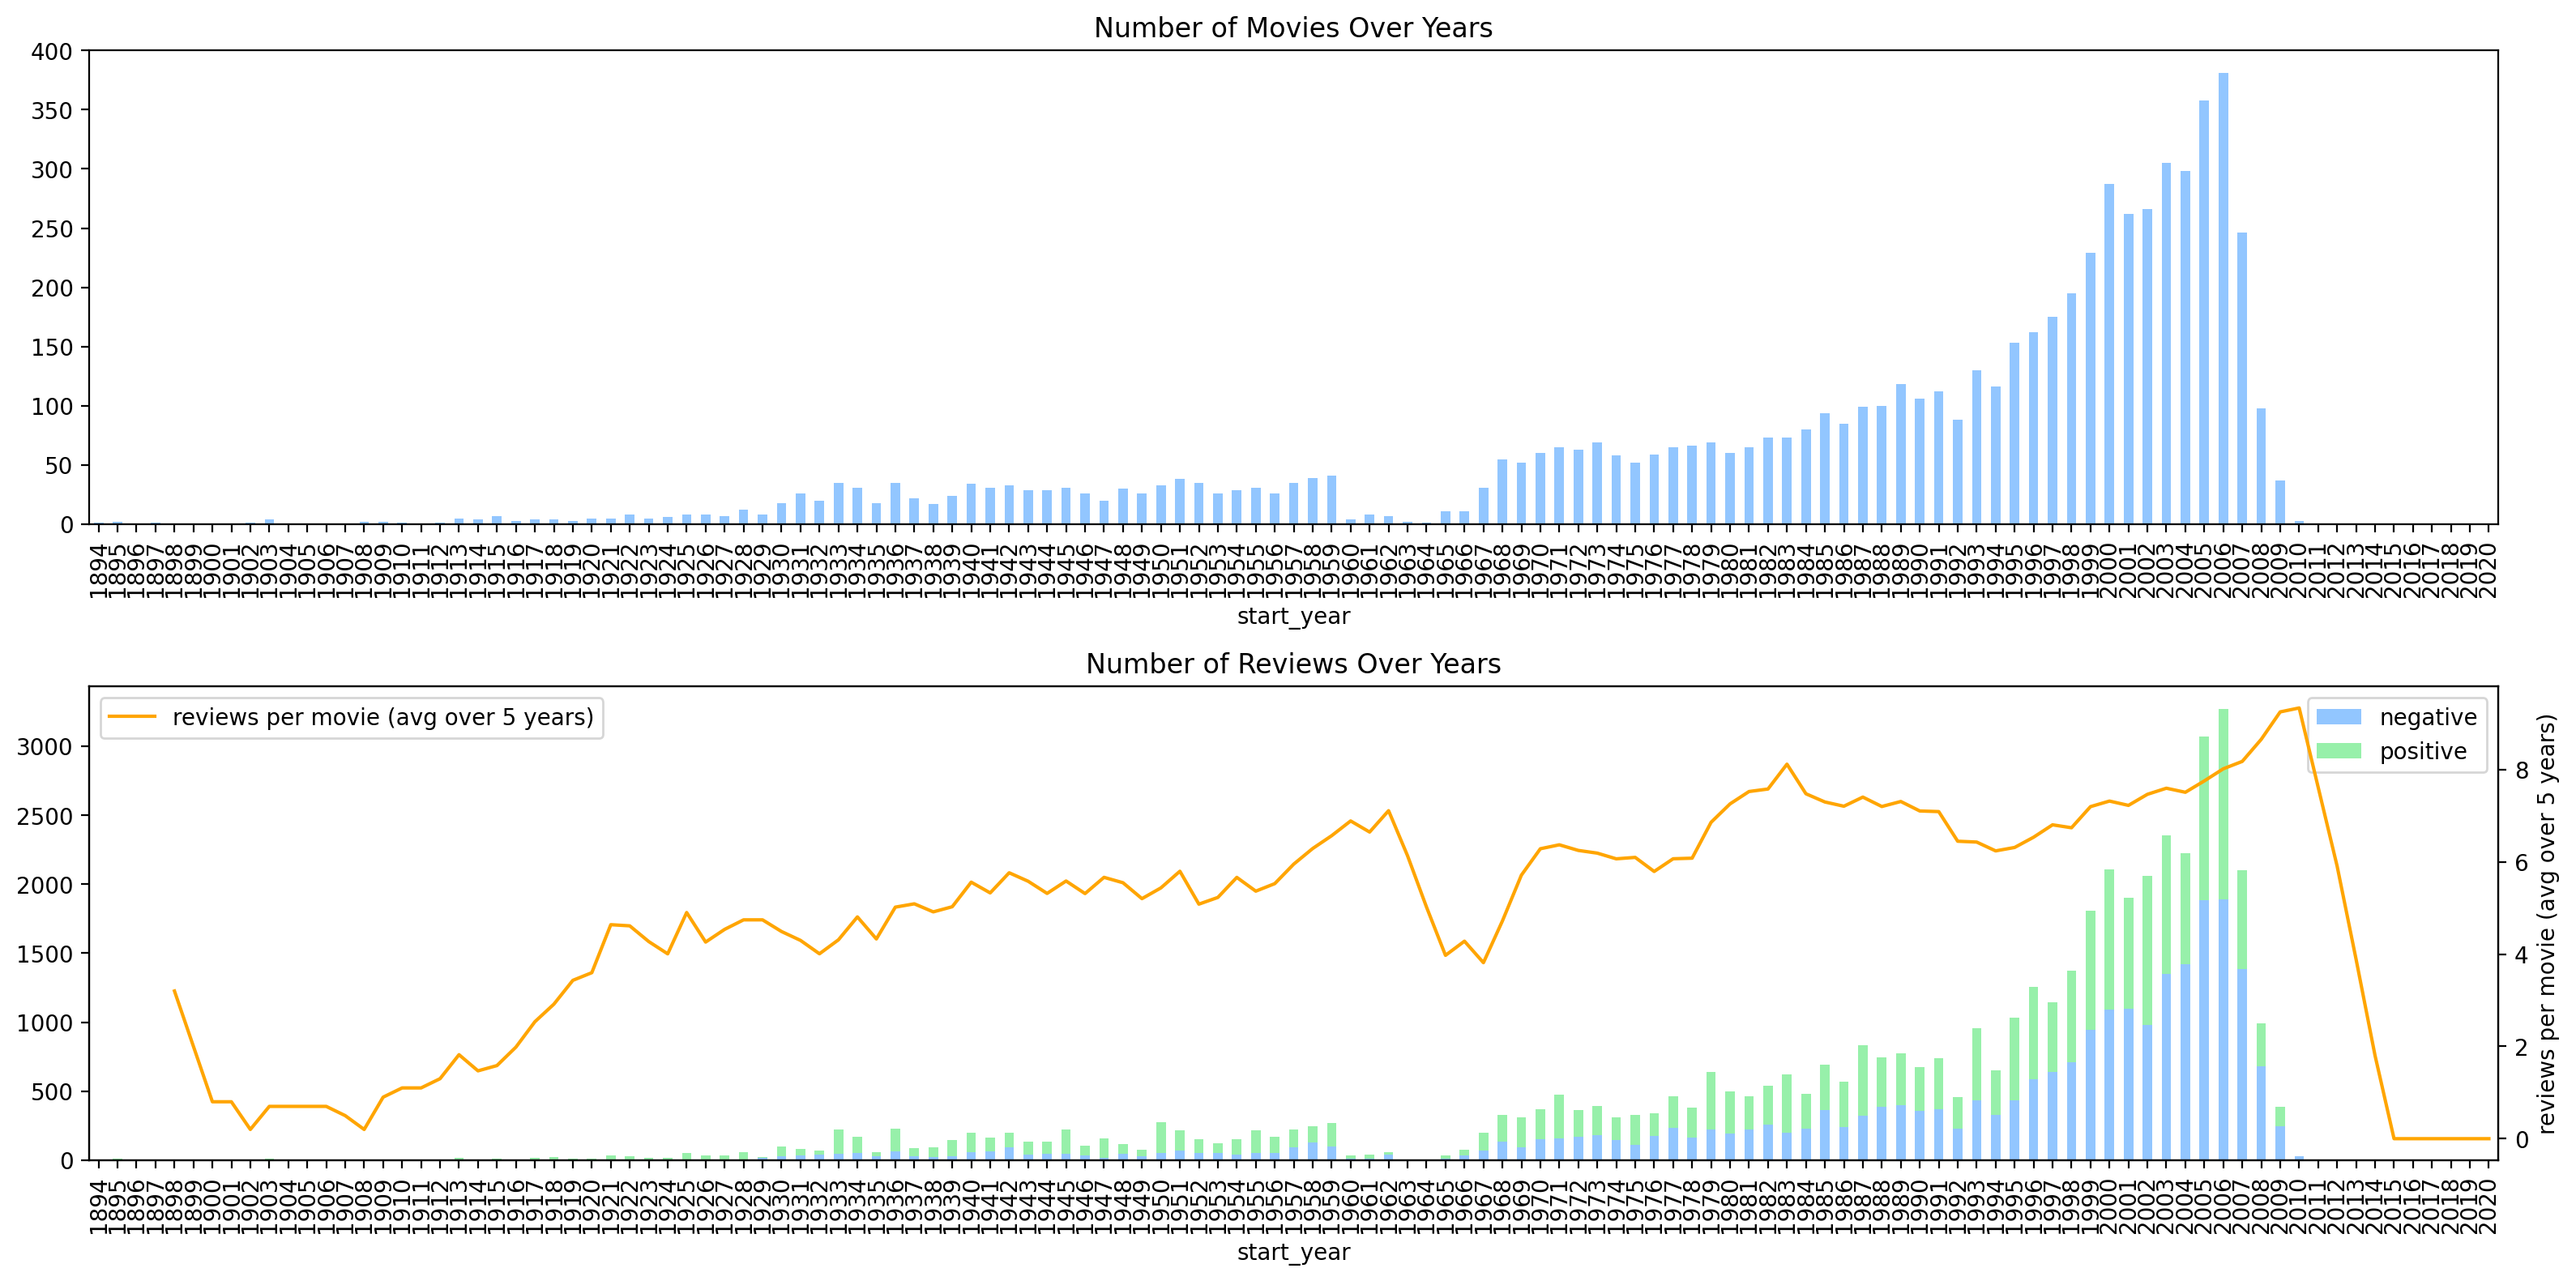

In [10]:
# Assuming df_reviews is your DataFrame

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Plot for number of movies over years
ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

# Plot for number of reviews over years
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

# Calculate reviews per movie (avg over 5 years)
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)

# Plot reviews per movie (avg over 5 years) on secondary y-axis
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# Set legends for each subplot
axt.legend(loc='upper left')
ax.set_title('Number of Reviews Over Years')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['negative', 'positive'], loc='upper right')

# Set labels for y-axis of the secondary subplot
axt.set_ylabel('reviews per movie (avg over 5 years)')

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()

**Analysis**: The number of movies and reviews per movie have increased over the years. The five year moving average shows a steady increase of reviews per movie, peaking over 8 in 2011. As reviews increase, it seems that negative reviews also increase which will be analysed more in the next section.

### Distribution of Review Type by Year

The proportion between positive and negative reviews will first be noted. Review type will then be assessed on a year to year basis to note if changes occur.

In [11]:
df_reviews['pos'].value_counts()

pos
0    23680
1    23560
Name: count, dtype: int64

An even amount of positive and negative reviews exist. No imbalance needs to be made for this metric. However, changing the balance for other features may consequently change this balance.

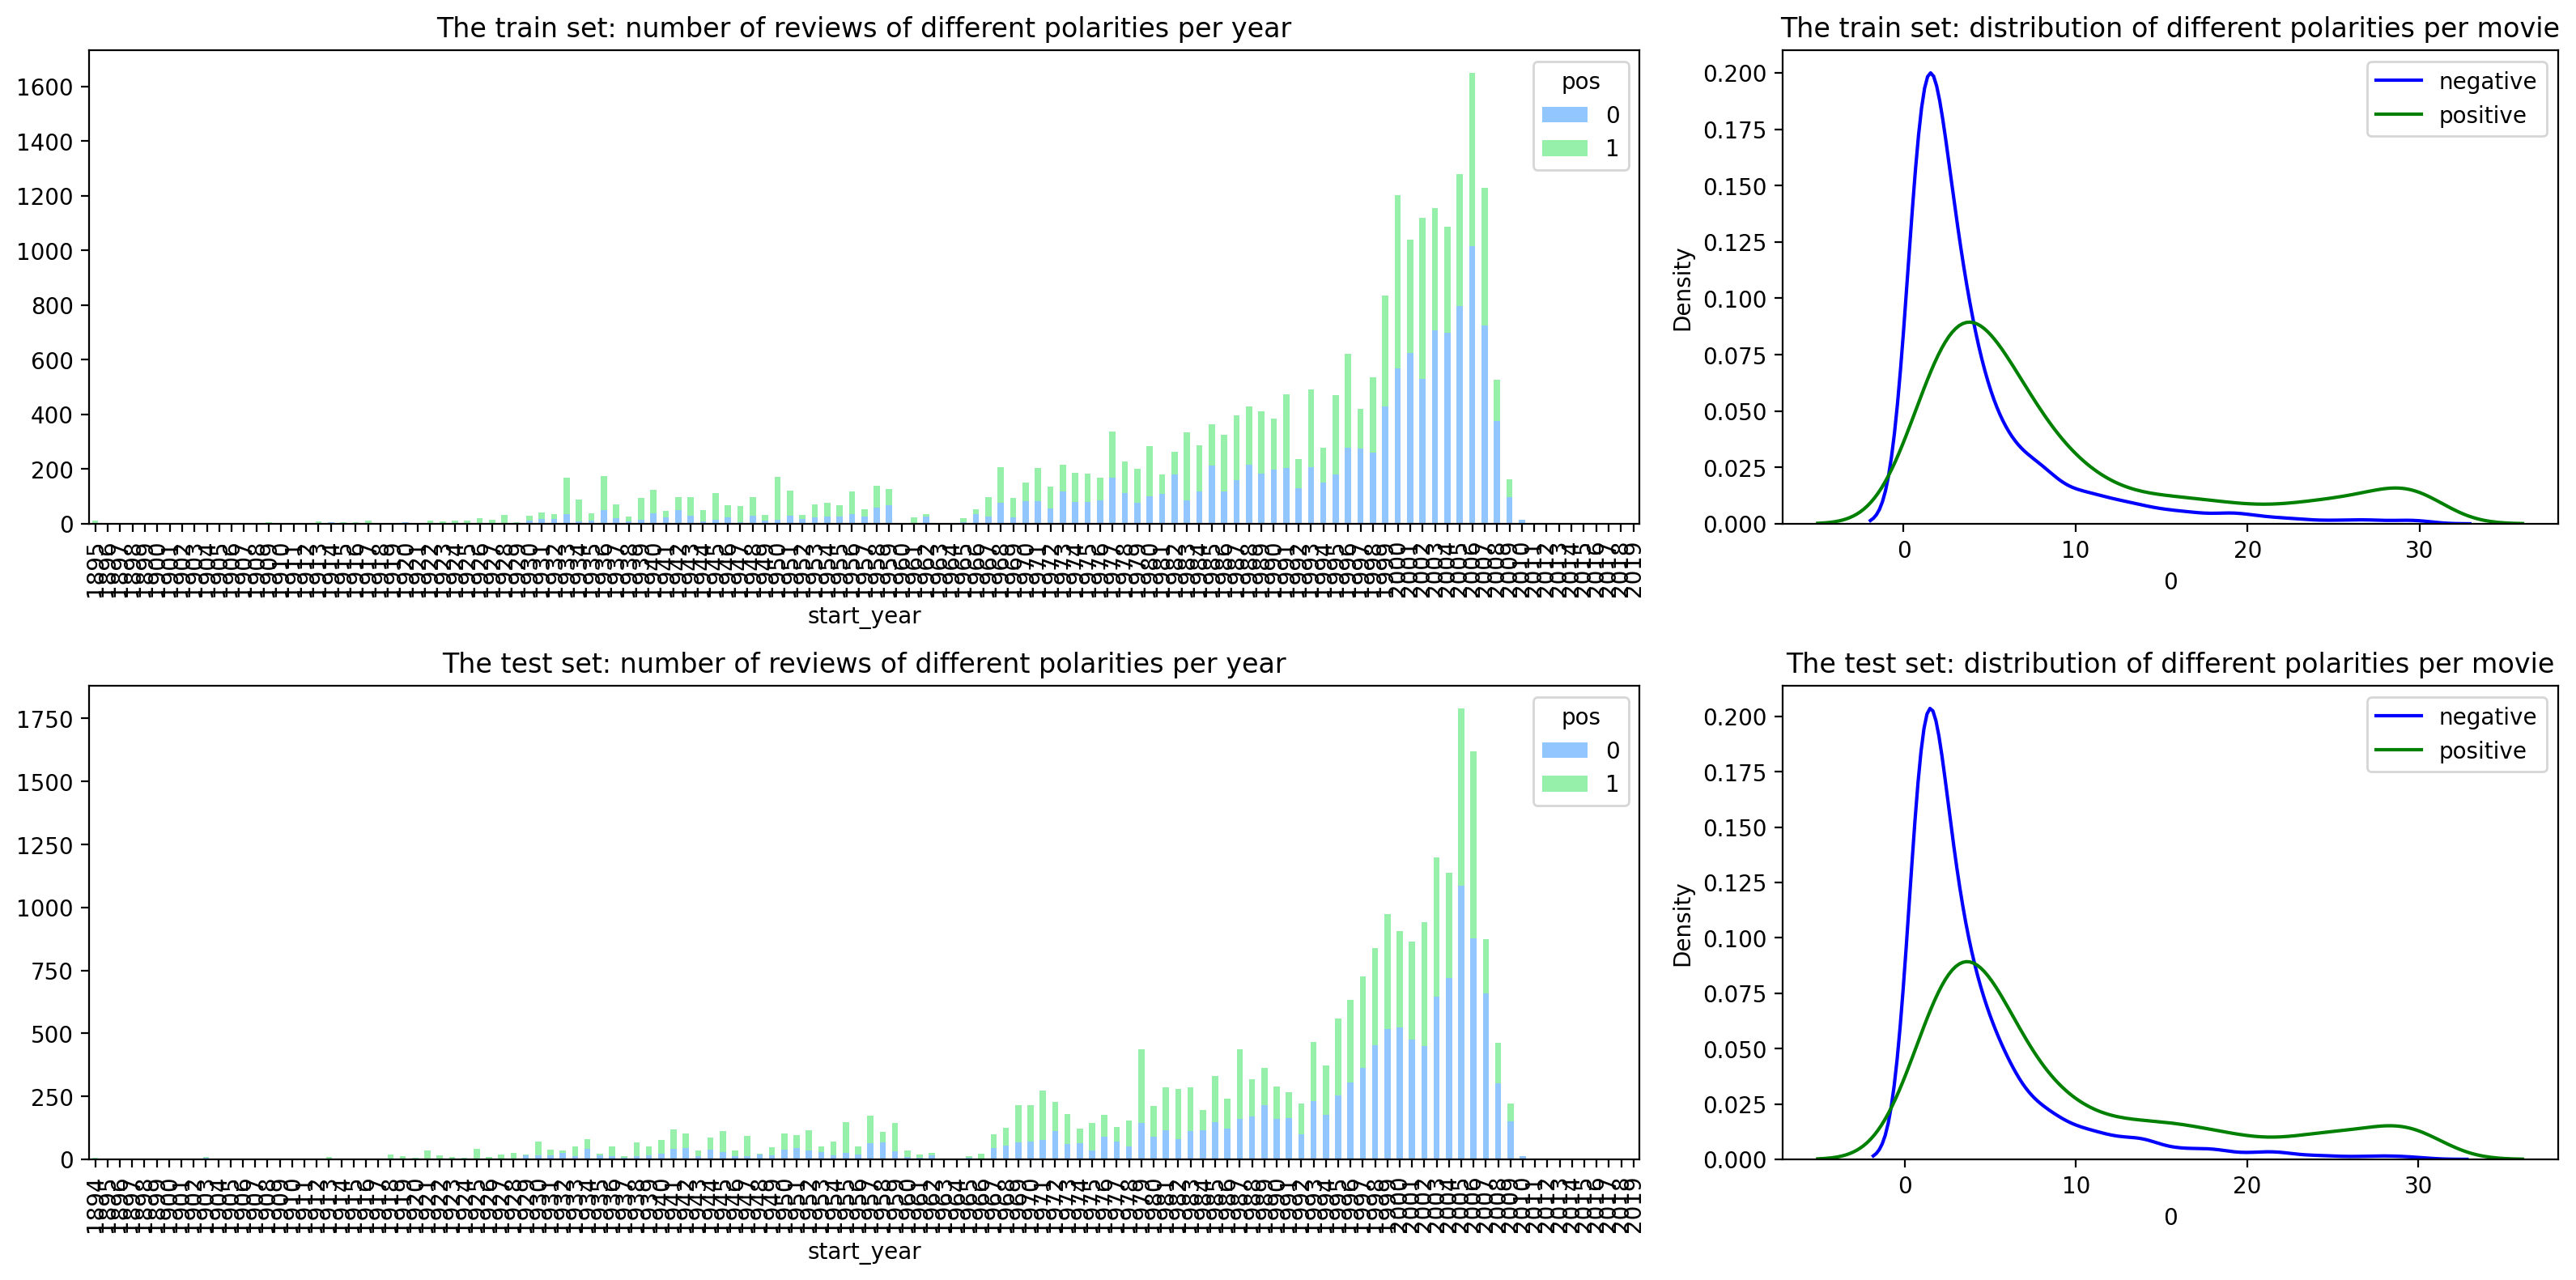

In [12]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Plot for the train set: number of reviews of different polarities per year
ax = axs[0][0]
dft_train = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft_train.index = dft_train.index.astype('int')
dft_train = dft_train.reindex(index=np.arange(dft_train.index.min(), max(dft_train.index.max(), 2020))).fillna(0)
dft_train.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

# Plot for the train set: distribution of different polarities per movie
ax = axs[0][1]
dft_train = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft_train[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft_train[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

# Plot for the test set: number of reviews of different polarities per year
ax = axs[1][0]
dft_test = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft_test.index = dft_test.index.astype('int')
dft_test = dft_test.reindex(index=np.arange(dft_test.index.min(), max(dft_test.index.max(), 2020))).fillna(0)
dft_test.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

# Plot for the test set: distribution of different polarities per movie
ax = axs[1][1]
dft_test = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft_test[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft_test[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

Recent years show that reviews are more negative than positive. Movies with less reviews tend to be more negative and movies with over 8 reviews tend to have more positive reviews. As changes exist that may cause an imbalance in results, looking to the text of the review is a more appropriate way to determine whether the sentiment is positive or negative.

### Distribution of Reviews by Movies

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

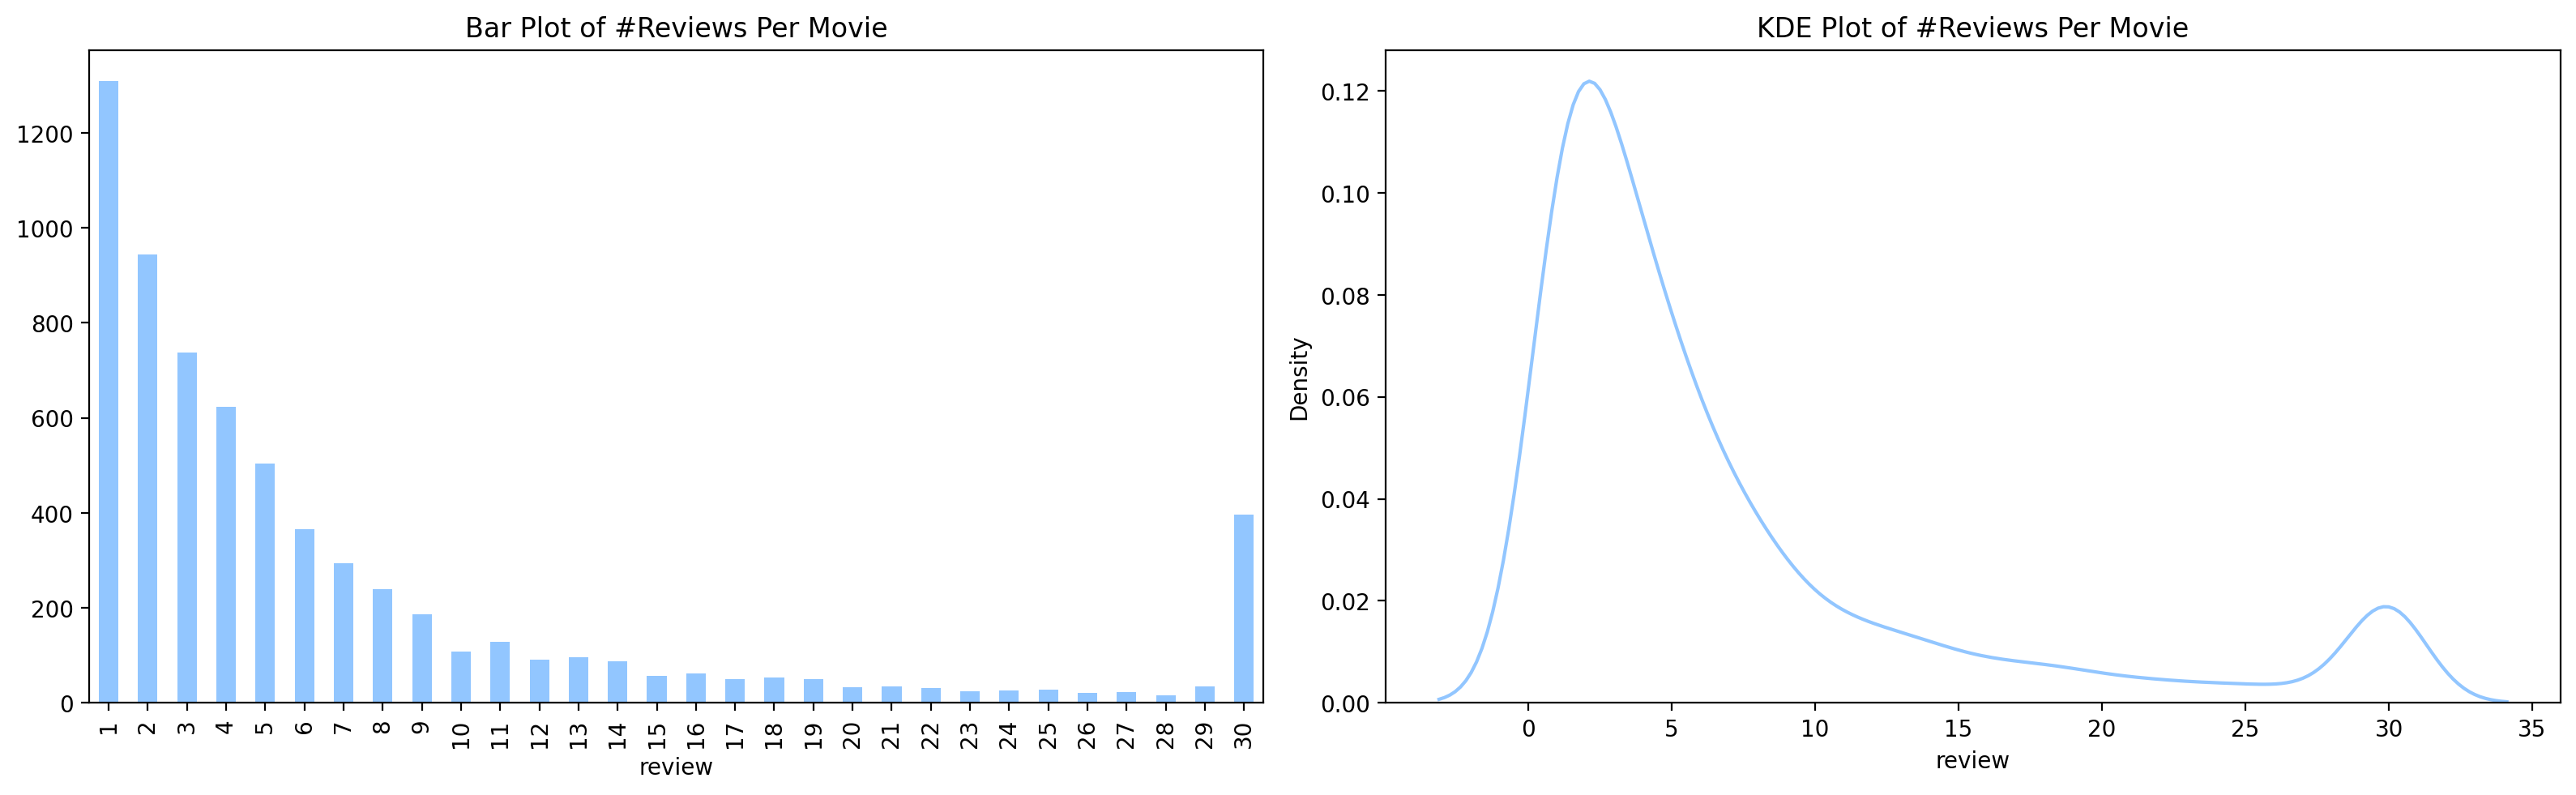

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

**Analysis**: Imbalances exist in the number of reviews per movie. Some movies have plenty of reviews, while many have very few. Movies that were released earlier show a lower average of the number of reviews than movies that have been released more recently. A clear imbalance between classes exists. These features should be disregarded for another model that looks to the text of the reviews.

### Distribution of Ratings

The distribution of ratings between the train and test set will be examined. 

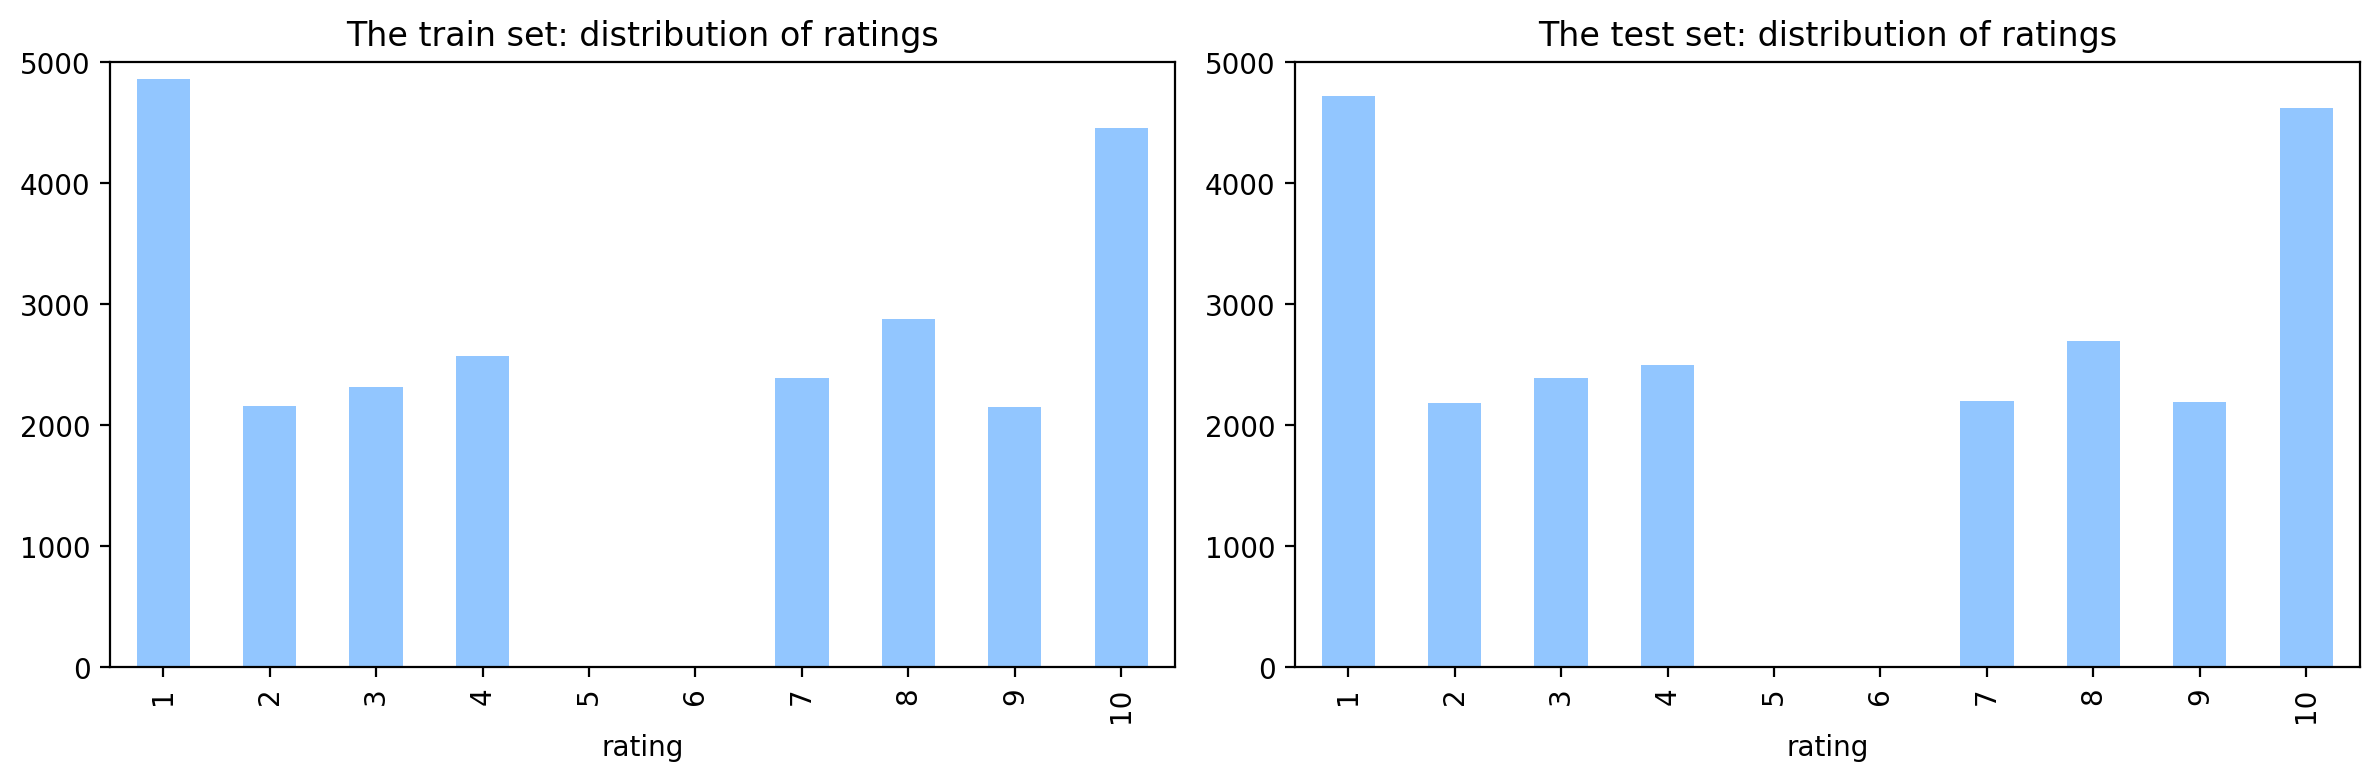

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

**Analysis**: The train and test set have a similar distribution for ratings. In reality, the test set may include more reviews that have ratings of 5 and 6. In these cases, sentiment would be more difficult to distinguish. A model that doesn't consider this metric should be used such as sentimental text analysis.

## Evaluation Procedure

An evaluation formula that returns an F1 score, ROC-AUC and PRC will be created. This will be applied to each model to determine which is the most effective.

In [15]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for data_type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        eval_stats[data_type] = {}

        # Predictions
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1 Score
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        max_f1_score_idx = np.argmax(f1_scores)

        # ROC Curve
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)

        # Precision-Recall Curve
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)

        # Plotting
        color = 'blue' if data_type == 'train' else 'green'

        # F1 Score
        ax = axs[0]
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{data_type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        ax.scatter(f1_thresholds[max_f1_score_idx], f1_scores[max_f1_score_idx], color='red', marker='X', label='Max F1', zorder=5)
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score')

        # ROC Curve
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{data_type}, ROC AUC={roc_auc:.2f}')
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower center')
        ax.set_title('ROC Curve')

        # Precision-Recall Curve
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{data_type}, APS={aps:.2f}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')

        # Evaluation Metrics
        eval_stats[data_type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[data_type]['F1'] = metrics.f1_score(target, pred_target)
        eval_stats[data_type]['ROC AUC'] = roc_auc
        eval_stats[data_type]['APS'] = aps

    # Display Evaluation Statistics
    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    print(df_eval_stats)

    return


## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [16]:
# make lowercase, replace non-alphabetic characters with space (except apostrophes)
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r'[^a-z\']', ' ', regex=True)

# remove apostrophes
df_reviews['review_norm'] = df_reviews['review_norm'].str.replace(r'\'', '', regex=True)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23759, 18)
(23481, 18)


## Working with models

A constant model, along with three other models will be created. Created models will vary between the language model used (either nltk or spaCy) and the type of model (linear regression or gradient boosting)



### Model 0 - Constant

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


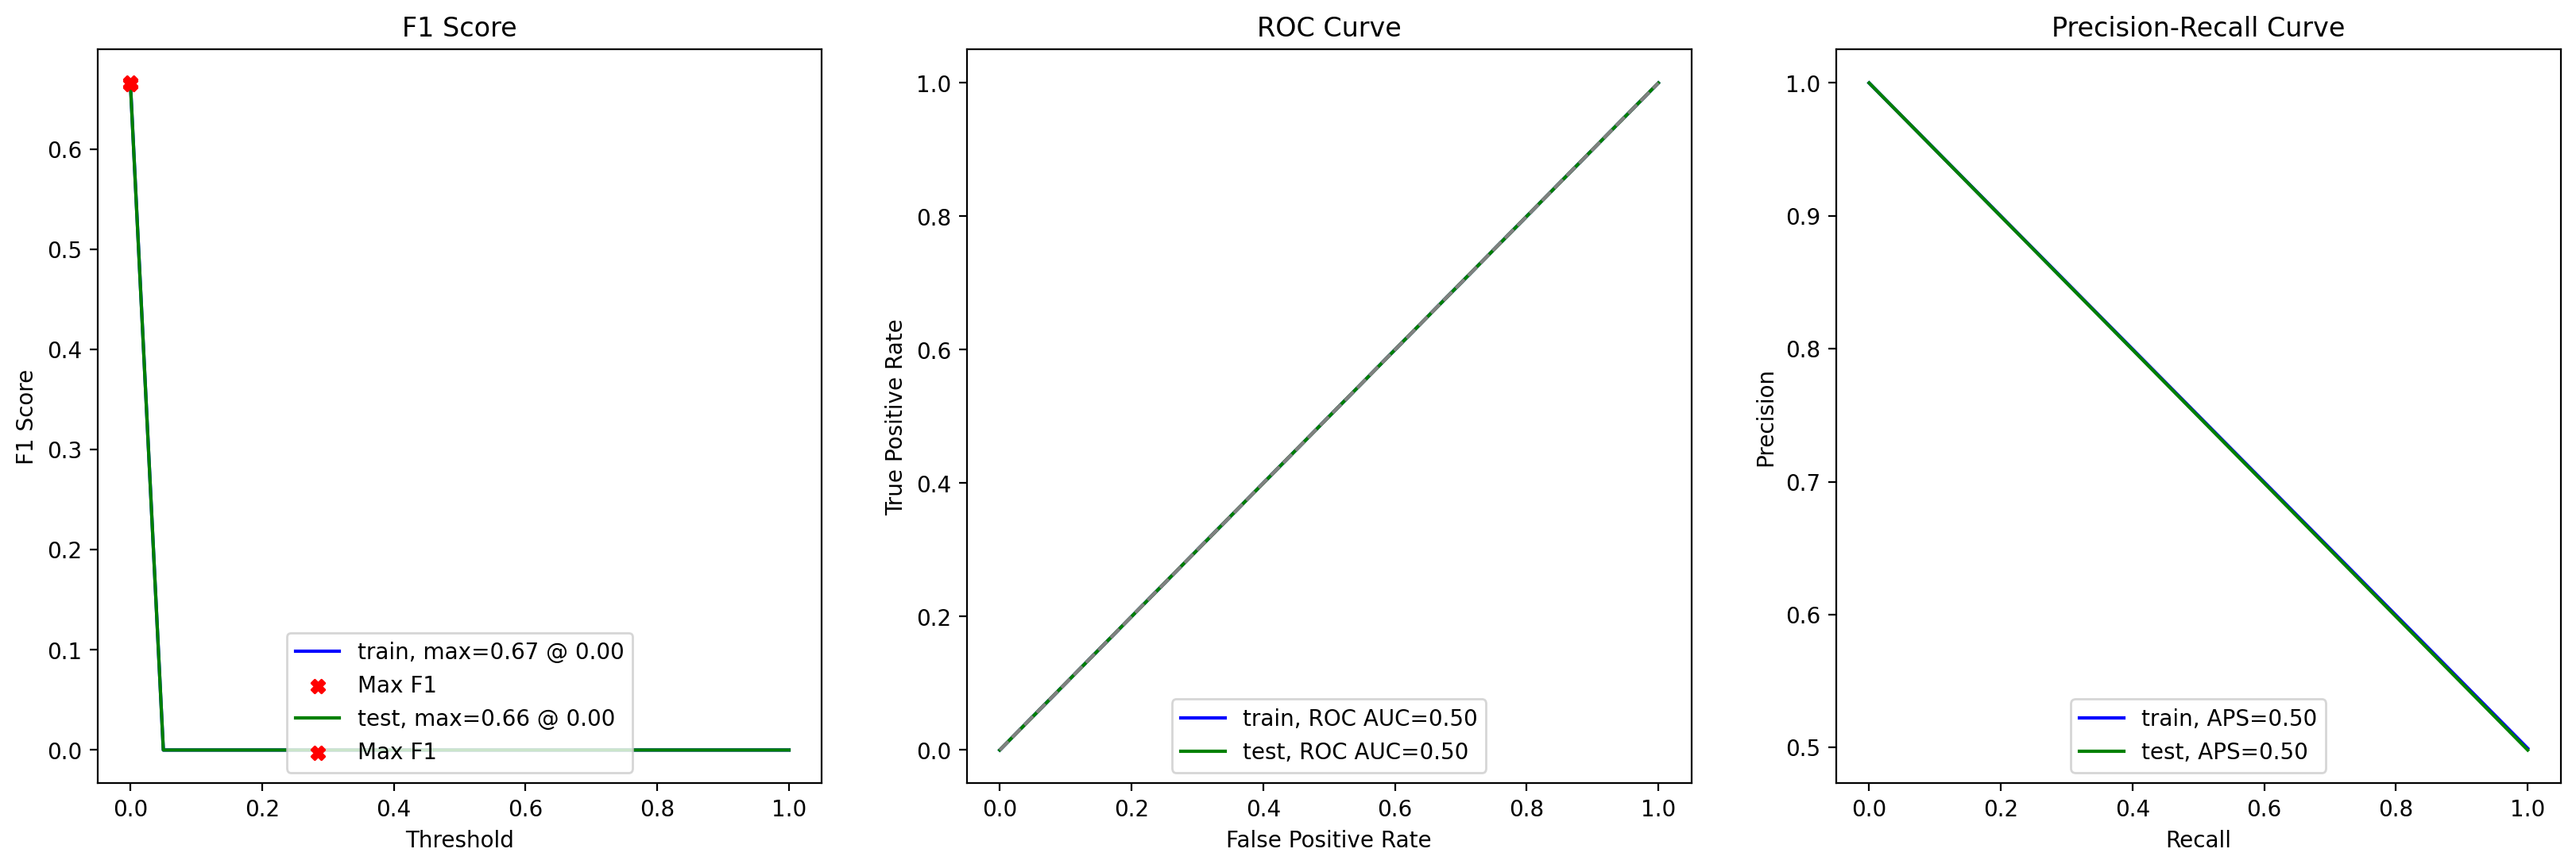

In [18]:
# set model to always predict the most frequent class
model = DummyClassifier(strategy='most_frequent')

# fit the model
model.fit(df_reviews_train[['review_norm']], train_target)

# evaluate the model
evaluate_model(model, df_reviews_train[['review_norm']], train_target, df_reviews_test[['review_norm']], test_target)

These results are what would be expected from a constant model as shown with the ROC curve. As the target is evenly split between positive and negative reviews, area under the curve would equal close to 50% as shown with the straight diagonal cut.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [19]:
# set corpus
corpus_train = df_reviews_train['review_norm']

# find stopwords
stop_words = list(stopwords.words('english'))

# create vectorizer
tf_idf = TfidfVectorizer(stop_words=stop_words, max_features=10000)

# train_features_1
train_features_1 = tf_idf.fit_transform(corpus_train)

# test_features_1
test_features_1 = tf_idf.transform(df_reviews_test['review_norm'])

# create model
model_1 = LogisticRegression(max_iter=1000)

# fit the model
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


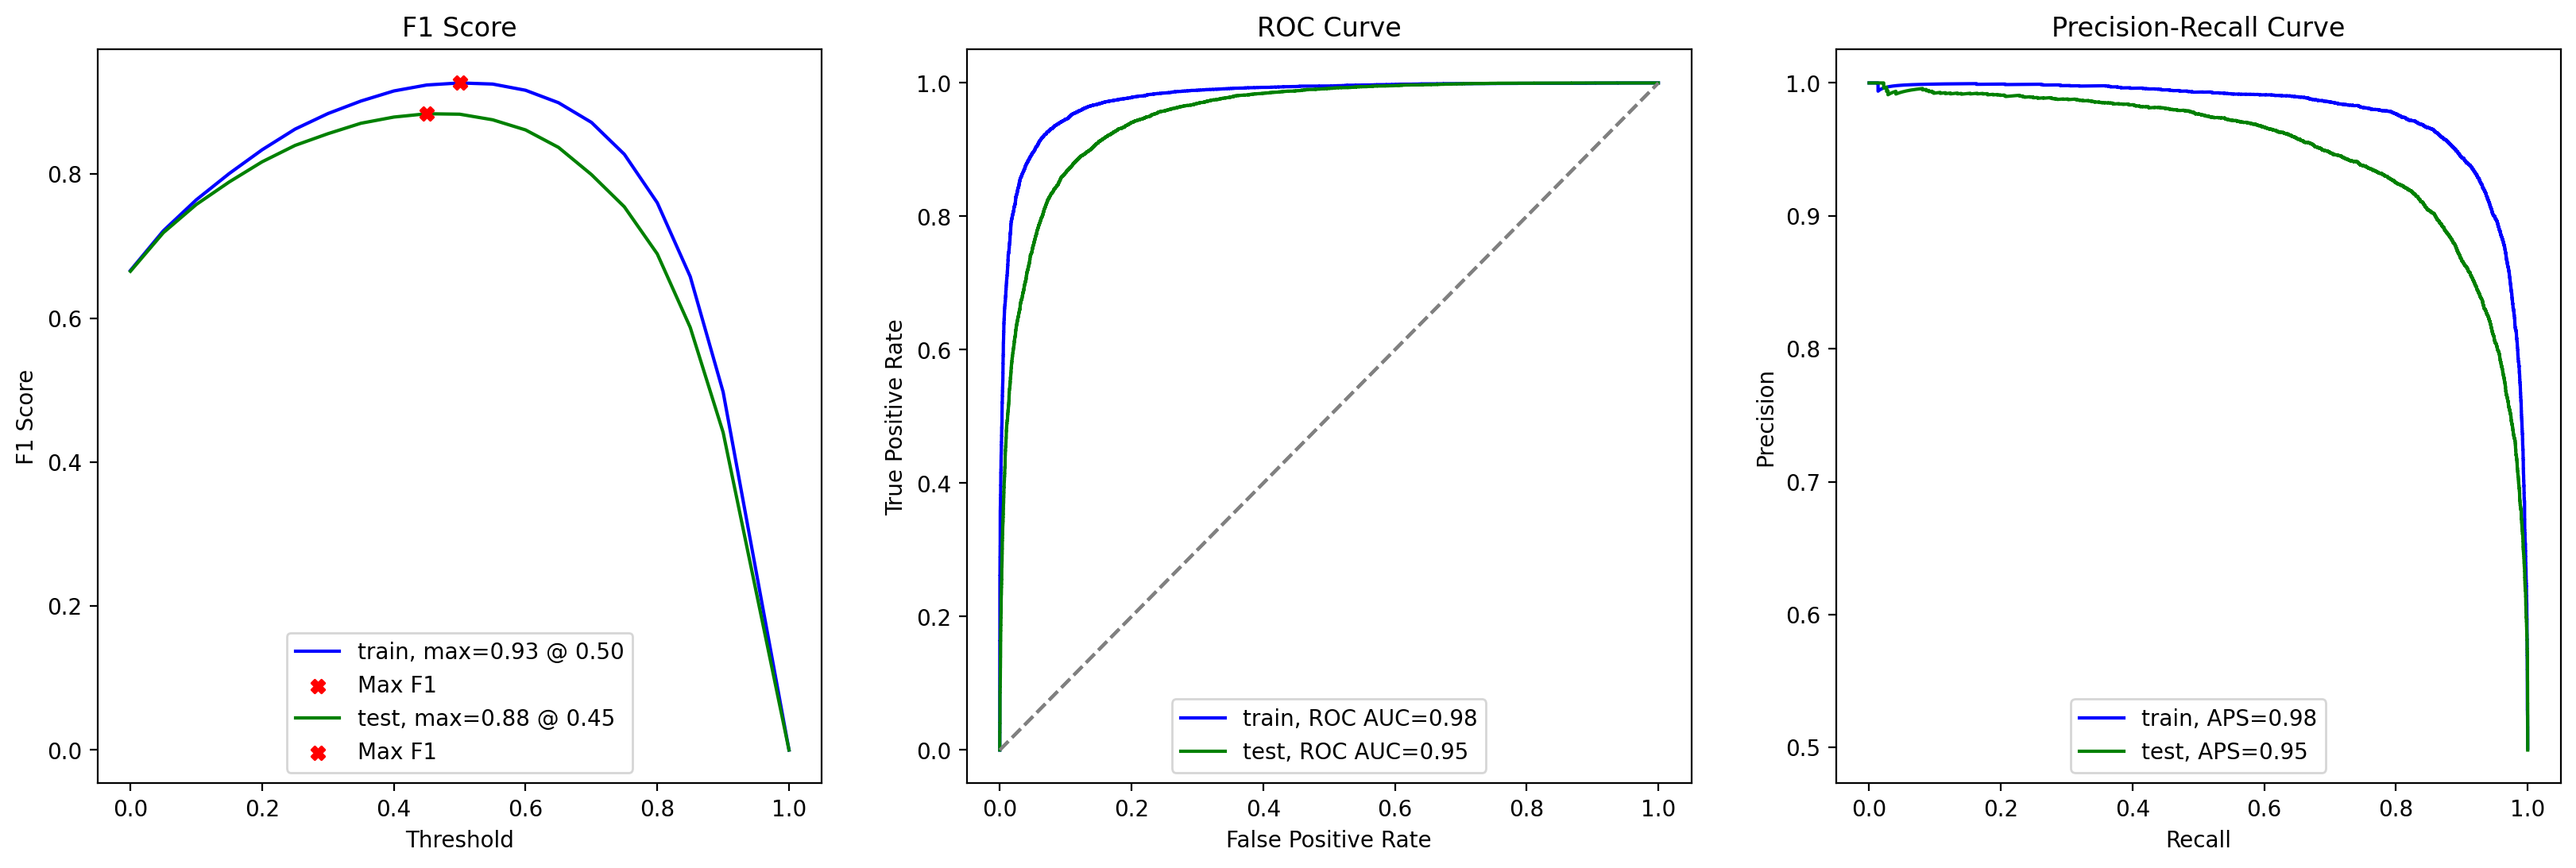

In [35]:
# save results
nltk_tfidf_lr_results = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

# show results
nltk_tfidf_lr_results

# save png of the plot
plt.savefig('nltk_tfidf_lr_results.png')

### Model 2 - spaCy, TF-IDF and LR

This model will use the spaCy package

In [21]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [22]:
def text_preprocessing(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [23]:
# apply the function to the review column within train set
df_reviews_train['review_nlp'] = df_reviews_train['review_norm'].apply(text_preprocessing)


In [24]:
# apply the function to the review column within test set
df_reviews_test['review_nlp'] = df_reviews_test['review_norm'].apply(text_preprocessing)

In [25]:
df_reviews_test['review_nlp']

2        there be no real story the film seem more like...
3        um       a serious film about troubled teen in...
4        I m totally agree with garryjohal from singapo...
5        this be the first movie I ve see from singapor...
6        yes non singaporeans can not see what s the bi...
                               ...                        
47326    this be another of my favorite columbo   it sp...
47327    talk about be bore   I get this expect a fasci...
47328    I never think I d say this about a biopic   bu...
47329    spirit and chaos be an artistic biopic of miya...
47330    ill make this brief   this be a joy to watch  ...
Name: review_nlp, Length: 23481, dtype: object

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


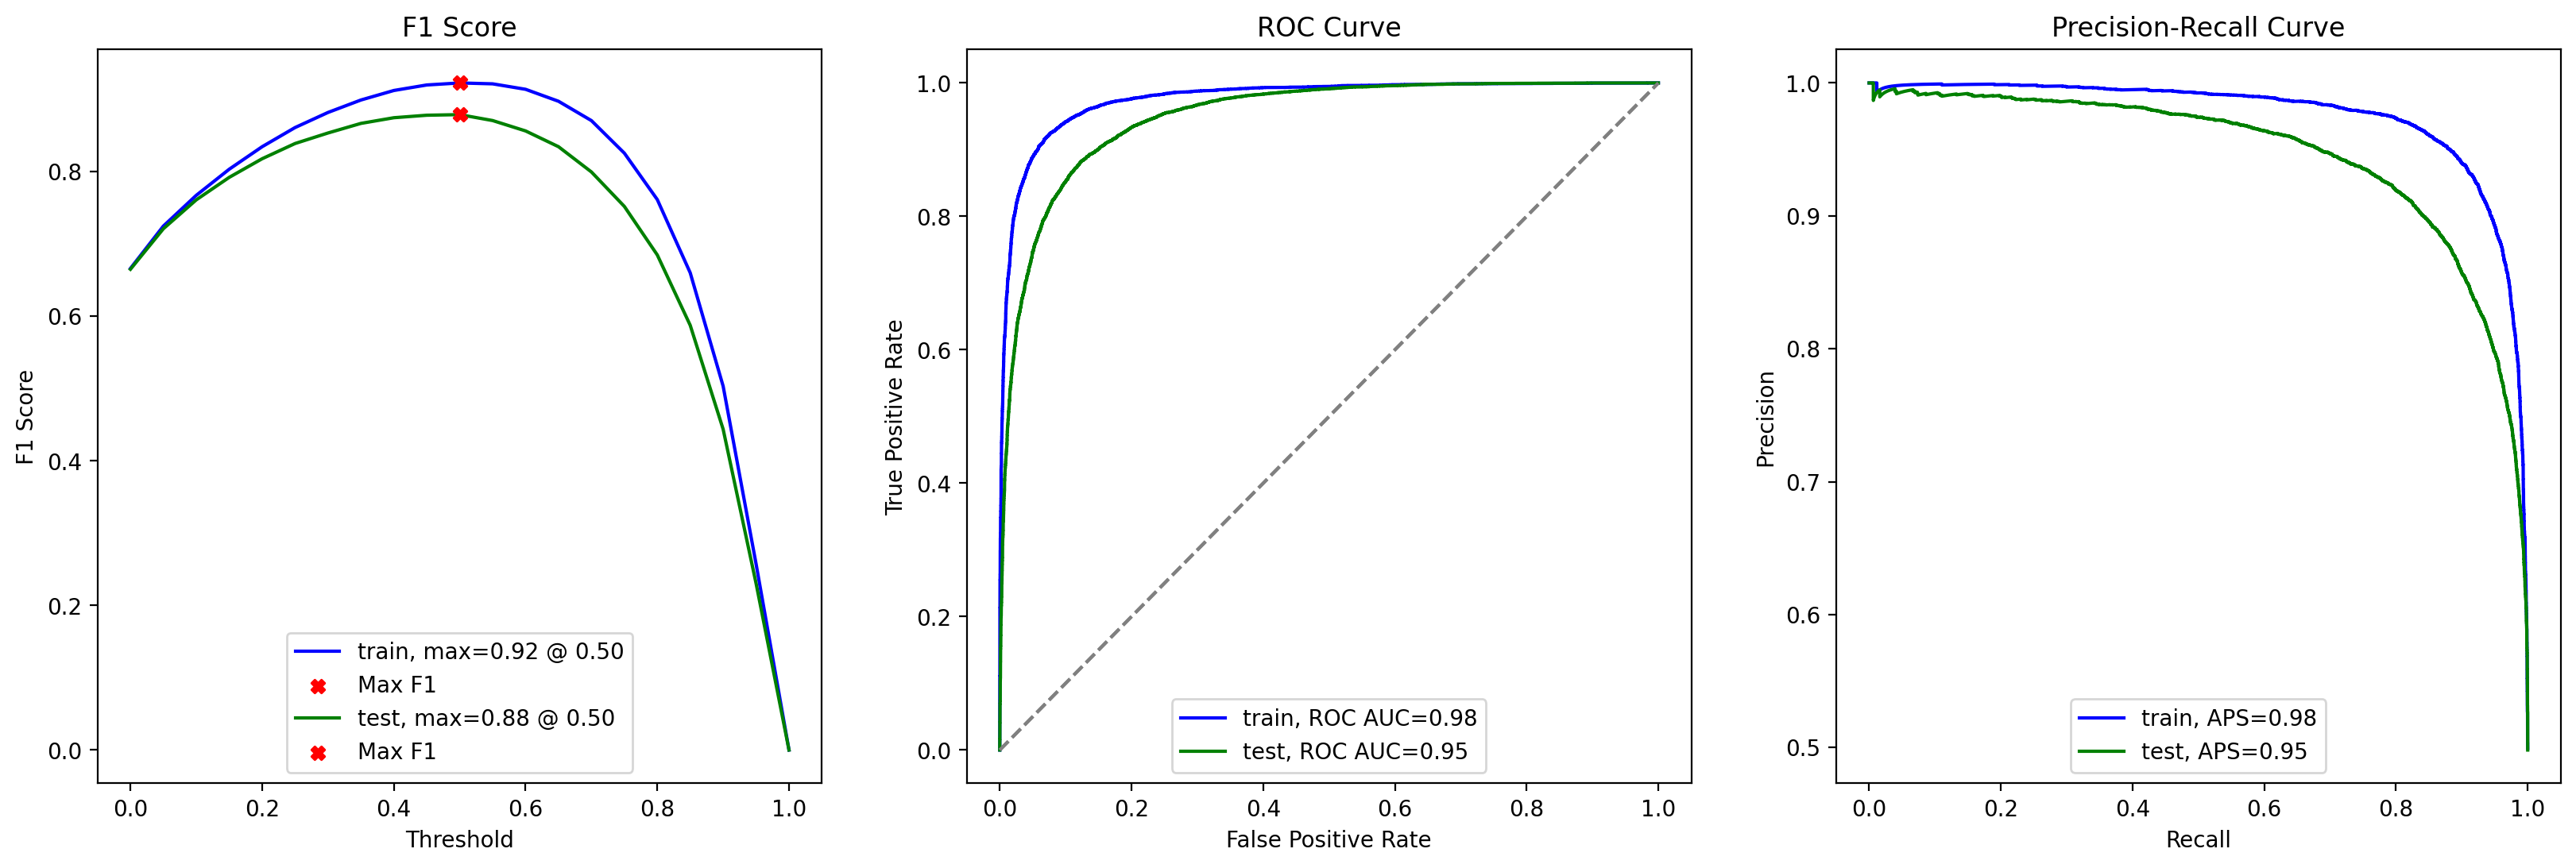

In [26]:
# train_features_2
train_features_2 = tf_idf.fit_transform(df_reviews_train['review_nlp'])

# test_features_2
test_features_2 = tf_idf.transform(df_reviews_test['review_nlp'])

# model_2
model_2 = LogisticRegression(max_iter=1000)

# fit the model
model_2 = model_2.fit(train_features_2, train_target)

# evaluate the model
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 3 - spaCy, TF-IDF and LGBMClassifier

          train  test
Accuracy   0.95  0.85
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


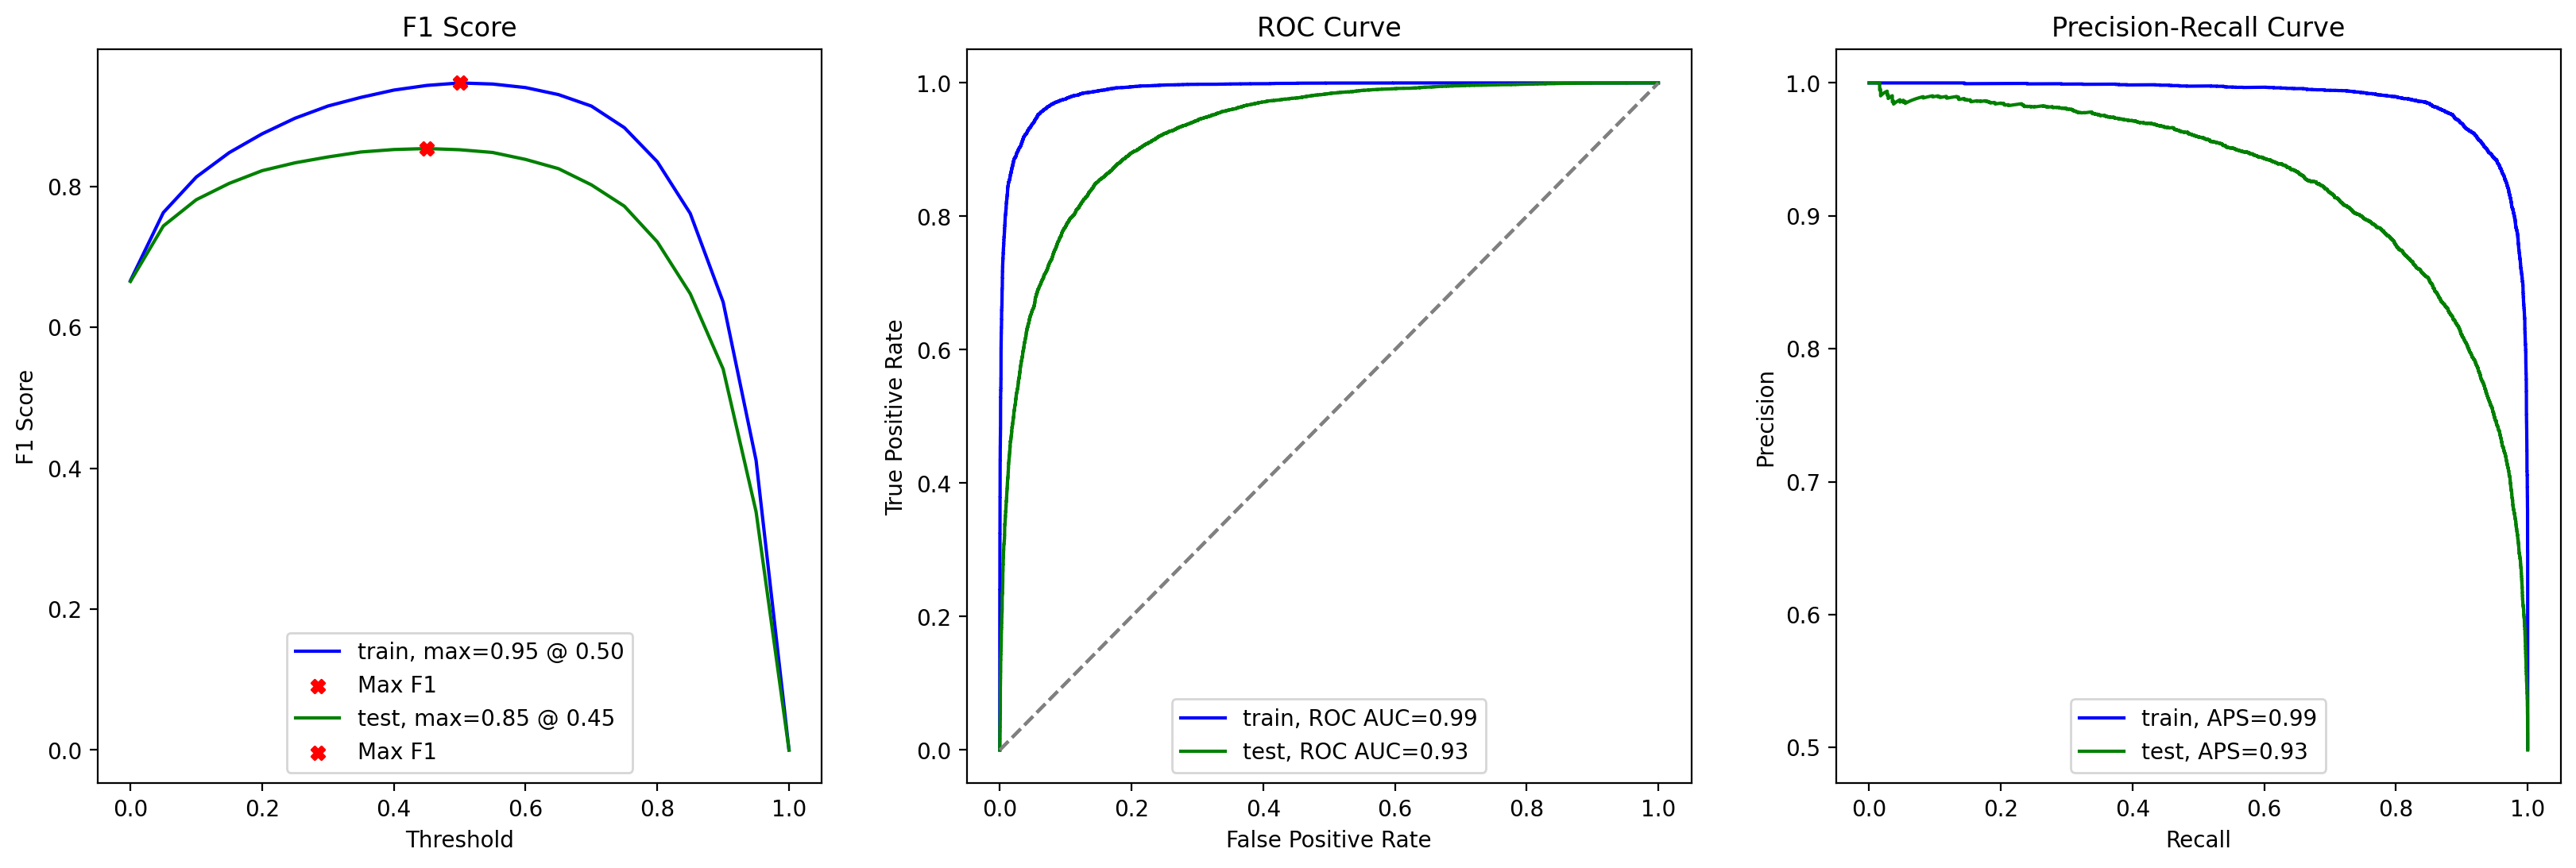

In [27]:
# create model
model_3 = xgb.XGBClassifier()

# fit the model
model_3 = model_3.fit(train_features_2, train_target)

# evaluate the model
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

The baseline set by the constant was beaten significantly by all other models. Both the first and second model performed similarly with identical scores for ROC-AUC and APS at 0.98 and 0.95 for the training and test sets respectively. Accuracy and F1 scores also matched identically on the test set at 0.88, but differed on the training set by 0.1 in favor of model 1. These similarities may be explained by the logistic regression model that was used to predict values as perhaps only small differences in the lemmatization process remain.


Model 3 performed significantly well, but behind models 1 and 2. This is likely because gradient boosting was used instead of logistic regression.

## My Reviews

A list of reviews will be made. Each model from above will then sort reviews into positive and negative as outcomes. These will be compared to eachother.

In [28]:
# Create reviews

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# make lowercase, replace non-alphabetic characters with space (except apostrophes)
my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace(r'[^a-z\']', ' ', regex=True)

# remove apostrophes
my_reviews['review_norm'] = my_reviews['review_norm'].str.replace(r'\'', '', regex=True)

# create pos column
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

# show my_reviews
my_reviews

,review,review_norm,pos
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,0
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...,0
2,I was really fascinated with the movie,i was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good write...,1
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...,1
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...,0
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...,1


In [29]:
texts = my_reviews['review_norm']

### Model 0 - Constant

The constant model has previously been fit as `model`.

In [30]:
# save texts from my_reviews
texts = my_reviews['review_norm']

# fit the constant model with my_reviews
my_reviews['constant'] = model.predict(texts)

### Model 1 - NLTK, TF-IDF and LR

In [31]:
# use logistic model run with nltk data (model_1)
my_reviews['nltk_tfidf_lr'] = model_1.predict_proba(tf_idf.transform(texts))[:, 1]

### Model 2 - spaCy, TF-IDF and LR

In [32]:
# overwrite texts with `review_norm`
texts = my_reviews['review_norm']

# preprocess text data
texts = texts.apply(text_preprocessing)

# predict using LR model (model_2)
my_reviews['spacy_tfidf_lr'] = model_2.predict_proba(tf_idf.transform(texts))[:, 1]

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [33]:
# predict using XBGClassifier (model_3)
my_reviews['spacy_tfidf_lgbm'] = model_3.predict_proba(tf_idf.transform(texts))[:, 1]

In [34]:
# show my_reviews
my_reviews.drop(columns = 'review_norm')

,review,pos,constant,nltk_tfidf_lr,spacy_tfidf_lr,spacy_tfidf_lgbm
0,"I did not simply like it, not my kind of movie.",0,0,0.495713,0.226331,0.624533
1,"Well, I was bored and felt asleep in the middl...",0,0,0.038999,0.140338,0.433042
2,I was really fascinated with the movie,1,0,0.399899,0.508909,0.624533
3,Even the actors looked really old and disinter...,0,0,0.583160,0.090386,0.495414
4,I didn't expect the reboot to be so good! Writ...,1,0,0.481967,0.191036,0.621279
5,"The movie had its upsides and downsides, but I...",1,0,0.654837,0.540343,0.694059
6,What a rotten attempt at a comedy. Not a singl...,0,0,0.256322,0.037996,0.372330
7,Launching on Netflix was a brave move & I real...,1,0,0.564273,0.945157,0.781043


## Conclusions

### Models on Train and Test Set

Only slight variations in results occurred due to lemmatization differences in the spaCy and NTLK. However, The type of model used had a greater effect. For instance, F1 scores showed a 0.02 increase when using the logistic regression model when compared to the gradient boosting model. 

### Models on `my_reviews`

The NLTK lemmatized model did the worst (excluding the constant). Models lemmatized with spaCy performed better. However, this is just a small sample and should not be read into with great detail.